## TVB-Framework command initialisation

In [1]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *

work_path = os.getcwd()
data_path = work_path
tvb_conn_filepath = os.path.join(data_path, "Connectivity_res100_596_regions.h5")
outputs_path = os.path.join(work_path, "outputs/cereb")
config = Config(output_base=outputs_path)

config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)


# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

2022-01-05 10:24:58,151 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-01-05 10:24:58,151 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-01-05 10:24:58,155 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-01-05 10:24:58,155 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-01-05 10:24:58,159 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-01-05 10:24:58,159 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-01-05 10:24:58,163 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2022-01-05 10:24:58,163 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2022-01-05 10:24:58,166 - INFO - tvb_multiscale.tv

# This loads the just-prepared data:

In [2]:
import h5py
from tvb.datatypes.connectivity import Connectivity

# Load connnectivity from file:
f = h5py.File(tvb_conn_filepath)
# We have to transpose the square connectivity matrices for TVB, because of the conversion w_ij => w_i<-j
result_connectivity = Connectivity(weights=np.array(f["weights"][()]).T, 
                                   tract_lengths=np.array(f["tract_lengths"][()]).T, 
                                   centres=np.array(f["centres"][()]), # hemispheres=np.array(f["hemispheres"][()]),
                                   region_labels=np.array(f["region_labels"][()]).astype("<U128"))
f.close()

# For the full connectome, self-connections are meaningless:
np.fill_diagonal(result_connectivity.weights, 0.0)
np.fill_diagonal(result_connectivity.tract_lengths, 0.0)

result_connectivity.configure()

print(result_connectivity.weights)
print(result_connectivity.region_labels)
print(result_connectivity.number_of_regions)
print(result_connectivity.weights.shape)
print(result_connectivity.tract_lengths.shape)




[[0.00000000e+00 3.63441680e-02 8.47970561e-02 ... 8.07329172e-07
  8.07329172e-07 1.02162597e-04]
 [3.32728901e-02 0.00000000e+00 5.49682272e-02 ... 2.73112949e-05
  2.85348052e-05 2.77993498e-05]
 [9.89313689e-02 6.43270451e-02 0.00000000e+00 ... 3.36029153e-05
  3.54584335e-05 9.15227954e-06]
 ...
 [1.36803986e-06 6.32084139e-05 2.99611362e-05 ... 0.00000000e+00
  1.00408312e-01 1.37087573e-02]
 [1.95515882e-07 5.04100941e-05 4.17897432e-05 ... 5.17439950e-02
  0.00000000e+00 2.65998675e-03]
 [2.71852623e-05 4.45484959e-04 2.03744779e-04 ... 3.86534058e-02
  3.67525396e-02 0.00000000e+00]]
['Right Frontal pole, cerebral cortex' 'Right Primary motor area'
 'Right Secondary motor area' 'Right Primary somatosensory area, nose'
 'Right Primary somatosensory area, barrel field'
 'Right Primary somatosensory area, lower limb'
 'Right Primary somatosensory area, mouth'
 'Right Primary somatosensory area, upper limb'
 'Right Primary somatosensory area, trunk'
 'Right Primary somatosensory a

## Summarize the major structures, except for the cerebellum

In [3]:
# Open the xls file and create a mapping between all regions and the major structures they belong each.

#pip install xlrd
try:
    import xlrd
except:
    import sys
    !{sys.executable} -m pip install xlrd
    import xlrd
    
sheet_data = []   
wb = xlrd.open_workbook(os.path.join(data_path, 'oh_table1.xls'))
p = wb.sheet_names()
#p[1]
#for y in p:
sh = wb.sheet_by_name(p[1])
print(sh)
for rownum in range(sh.nrows):
    sheet_data.append((sh.row_values(rownum)))

found_list = []
voxel_count = []
rows_to_be_saved = []
regions_missing = []
cc=0

for j in result_connectivity.region_labels: #go over the region labels
    j=j.split(" ",1)[1]
    #let us get rid of the left or right
    a=len(found_list)
    for i in sheet_data:
        if i[3] == j: #or i[2] == "string2" or i[2] == "string3" or i[2] == "string4" or i[2] == "string5":
            found_list.append(i[4])
            if i[5]:
                voxel_count.append(int(i[5]))
            else:
                voxel_count.append(-1)
        else:
            rows_to_be_saved.append(i)
    
    b=len(found_list)
    if a == b:
        regions_missing.append(j)
        found_list.append('X')
        voxel_count.append(-1)
        print(a,b)
    
    b=len(found_list)
    cc+=1
    if b != cc:
        print(b,cc)
print("Regions missing:\n%s" % str(regions_missing))
n_regs = len(found_list)
print("Number of regions: %d" % n_regs)
n_regs2 = n_regs/2
major_structures_labels = ["Right " + msl if iL <n_regs2 else "Left " + msl 
                           for iL, msl in enumerate(found_list)]
voxel_count = np.array(voxel_count).astype('i')
major_structures = np.unique(major_structures_labels)
print(major_structures)


Sheet  1:<Voxel Count_295 Structures>
Regions missing:
[]
Number of regions: 596
['Left Cerebellar Cortex' 'Left Cerebellar Nuclei'
 'Left Cortical Subplate' 'Left Hippocampal Formation' 'Left Hypothalamus'
 'Left Isocortex' 'Left Medulla' 'Left Midbrain'
 'Left Nonspecific Thalamus' 'Left Olfactory Areas' 'Left Pallidum'
 'Left Pons Behavioral' 'Left Pons Motor' 'Left Pons Sensory'
 'Left Spinal nucleus of the trigeminal' 'Left Striatum' 'Left Thalamus'
 'Right Cerebellar Cortex' 'Right Cerebellar Nuclei'
 'Right Cortical Subplate' 'Right Hippocampal Formation'
 'Right Hypothalamus' 'Right Isocortex' 'Right Medulla' 'Right Midbrain'
 'Right Nonspecific Thalamus' 'Right Olfactory Areas' 'Right Pallidum'
 'Right Pons Behavioral' 'Right Pons Motor' 'Right Pons Sensory'
 'Right Spinal nucleus of the trigeminal' 'Right Striatum'
 'Right Thalamus']


In [4]:
# Find the connections FROM Isocortex nodes TO the Reticular Thalamic Nucleus and store them:
crtx_inds = np.where(["Isocortex" in lbl for lbl in major_structures_labels])[0]
rtn_inds = np.where(["Reticular nucleus of the thalamus" in reg for reg in result_connectivity.region_labels])[0]

crtx_to_rtn_conns = result_connectivity.weights[rtn_inds][:, crtx_inds]
print(crtx_to_rtn_conns.shape)
print(crtx_to_rtn_conns)

(2, 86)
[[3.94103515e-02 4.62908399e-02 4.25861704e-02 2.73216337e-02
  3.93264514e-02 5.48581343e-02 3.03613826e-02 3.00756984e-02
  5.92247122e-02 3.19735059e-02 2.91188012e-02 2.66919324e-02
  2.12177573e-02 2.27831256e-02 1.96016289e-02 2.47299467e-02
  2.63869841e-02 4.26837150e-02 4.98592113e-02 3.94908753e-02
  3.17221751e-02 3.04147251e-02 4.60984772e-02 3.92240510e-02
  2.07935198e-02 5.28740999e-02 2.85178017e-02 3.68898511e-02
  1.70495636e-02 3.63003796e-02 2.89741678e-02 4.15611877e-02
  3.72741225e-02 1.86881257e-02 1.93450553e-02 4.00610279e-02
  3.43157286e-02 4.17920666e-02 5.02811332e-02 4.55077225e-02
  1.83633045e-02 7.88854174e-03 8.93559970e-03 1.89210197e-04
  3.91939639e-04 2.58313287e-04 6.83682439e-05 3.54658277e-05
  5.74742209e-04 7.75324981e-05 3.54404681e-05 1.30130420e-04
  5.07669322e-05 7.08662466e-05 1.16232715e-04 7.60481914e-05
  2.19341049e-06 2.03103407e-06 3.54591256e-06 3.59392604e-05
  1.27345877e-05 3.13776250e-04 1.80912111e-04 1.00330239e-04


In [5]:
from copy import deepcopy


def voxel_count_sum(arr, axis=0, **kwargs):
    voxel_count_sum = np.sum(arr[arr>0], axis=axis)
    print("Voxel count sum: %s" % str(voxel_count_sum))
    return voxel_count_sum

    
def repeat(arr, sub, axis=0, **kwargs):
    """This function will tile a subarray
       to create an array of shape similar to the input array's arr, 
       except for the axis given in the input, where size will be 1.
       It is used to substitute many labels by a single one."""
    shape = list(arr.shape)
    shape[axis] = 1
    return np.tile(sub, tuple(shape))
    

def delete(arr, axis=0, **kwargs):
    """This function returns an empty array 
       of shape similar to the input array's arr, 
       except for the axis given in the input, where size will be 0.
       It is used to delete a subarray."""
    shape = list(arr.shape)
    shape[axis] = 0
    return np.empty(tuple(shape))


def insert_axis(arr, arr_to_insert=None, inds=None, axis=0, def_value=0.0):
    if inds is None:
        inds = [arr.shape[axis]]
    if arr_to_insert is None:
        arr_to_insert = np.tile(def_value, np.take(arr, [-1], axis=axis).shape)
    return np.insert(arr, inds, arr_to_insert, axis=axis)


def merge_axis(inds, arr, axis=0, fun=np.nansum):
    """This function will merge a subarray of the input array arr,
       as defined by the input indices inds, along the input axis,
       applying the function fun, in order to summarize the values."""
    new_arr = np.delete(arr, inds, axis)
    array_to_be_merged = np.take(arr, inds, axis)
    merged_arr = fun(array_to_be_merged, axis, keepdims=True)
    return insert_axis(new_arr, merged_arr, [np.minimum(inds[0], new_arr.shape[axis])], axis=axis)
    # return np.insert(new_arr, [np.minimum(inds[0], new_arr.shape[axis])], merged_arr, axis=axis)
    
    
def merge_nD(inds, arr, fun=np.nansum):
    """This function will merge a subarray of the input array arr,
       as defined by the input indices inds, 
       along all the axes of arr (assuming same dimensionality along all axes),
       applying the function fun, in order to summarize the values."""
    new_arr = arr.copy()
    for ax in range(arr.ndim):
        new_arr = merge_axis(inds, new_arr, axis=ax, fun=fun)
    return new_arr


def merge_conn(conn, regions, new_label, weight_fun=np.nansum, configure=False):
    """This function will merge an input TVB connectivity conn, 
       for the input regions (indices or labels), 
       substituting them with a summarized region of label new_label, 
       applying the summary function for the connectivity weights weight_fun.
       If configure is True, the new connectivity will also be configured."""
    if np.issubdtype(regions.dtype, np.integer):
        inds = regions
    else:
        inds = []
        for iR, region in conn.region_labels:
            if region in regions:
                inds.append(iR)
    new_conn = deepcopy(conn)
    repeat_fun = lambda arr, axis=0, **kwargs: repeat(arr, new_label, axis, **kwargs)
    new_conn.region_labels = merge_axis(inds, conn.region_labels, axis=0, fun=repeat_fun)
    new_conn.centres = merge_axis(inds, conn.centres, axis=0, fun=np.nanmean)
    new_conn.weights = merge_nD(inds, conn.weights, fun=weight_fun)
    new_conn.tract_lengths = merge_nD(inds, conn.tract_lengths, fun=np.nanmean)
    if configure:
        new_conn.configure()
    return new_conn

    
def merge_major_structure(conn, major_struct_to_merge, major_structs_labels, voxel_count,
                          exclude_regions=[], weight_fun=np.nansum, configure=False):
    """This function will merge an input TVB connectivity conn, 
       for the input major structure label major_struct_to_merge,
       assuming an input vector major_structs_labels, mapping all regions to a major structure,
       substituting merged regions with a summarized region of the major structure label, 
       and applying the summary function for the connectivity weights weight_fun.
       If configure is True, the new connectivity will also be configured."""
    regions_inds = np.where([major_structs_label == major_struct_to_merge and 
                             region not in exclude_regions 
                             for region, major_structs_label in zip(conn.region_labels, major_structs_labels)])[0]
    print("...%d regions' indices of %s:\n%s" % (len(regions_inds), major_struct_to_merge, str(regions_inds)))
    repeat_fun = lambda arr, axis=0, **kwargs: repeat(arr, major_struct_to_merge, axis, **kwargs)
    return merge_conn(conn, regions_inds, major_struct_to_merge, weight_fun=weight_fun, configure=configure), \
           merge_axis(regions_inds, major_structs_labels, axis=0, fun=repeat_fun), \
           merge_axis(regions_inds, voxel_count, axis=0, fun=voxel_count_sum) 
    
    
def merge_major_structures(conn, major_structs_to_merge, major_structs_labels, voxel_count, 
                           exclude_regions={}, weight_fun=np.nansum):
    """This function will merge an input TVB connectivity conn, 
       for the input major structures labels major_structs_to_merge,
       assuming an input vector major_structs_labels, mapping all regions to a major structure,
       substituting merged regions with a summarized region of the respective major structure label, 
       and applying the summary function for the connectivity weights weight_fun.
       If configure is True, the new connectivity will also be configured."""
    new_conn = deepcopy(conn)
    new_major_structs_labels = major_structs_labels.copy()
    new_voxel_count = voxel_count.copy()
    for major_struct_to_merge in major_structs_to_merge:
        print("Merging %s ..." % major_struct_to_merge)
        new_conn, new_major_structs_labels, new_voxel_count = \
            merge_major_structure(new_conn, major_struct_to_merge, 
                                  new_major_structs_labels, new_voxel_count, 
                                  exclude_regions=exclude_regions.get(major_struct_to_merge, []), 
                                  weight_fun=weight_fun)
        
    new_conn.configure()
    return new_conn, new_major_structs_labels, new_voxel_count



In [6]:
def unilateral_to_bilateral_exclude_regions(major_structure, hemi, exclude_regions):
    new_exclude_regions = []
    if len(exclude_regions):
        if hemi == "Left":
            hemistr = "Left "
            hemidel = "Right "
        else:
            hemistr = "Right "
            hemidel = "Left "
        for reg in exclude_regions:
            if hemistr in reg:
                new_exclude_regions.append(reg)
            elif hemidel in reg:
                pass
            else:
                new_exclude_regions.append(hemistr + reg)
    return new_exclude_regions


    
def unilateral_to_bilateral(major_structures_to_merge, exclude_regions):
    # For bilateral merge: 
    new_major_structures_to_merge = []
    new_exclude_regions = {}
    for mstm in major_structures_to_merge:
        if "Left " not in mstm and "Right " not in mstm:
            left = "Left " + mstm
            new_major_structures_to_merge.append("Left " + mstm)
            new_major_structures_to_merge.append("Right " + mstm)
        else:
            new_major_structures_to_merge.append(mstm)
    new_major_structures_to_merge = np.unique(new_major_structures_to_merge)
    for hemimstm in new_major_structures_to_merge:
        if "Left " in hemimstm:
            hemi = "Left"
            mstm = hemimstm.split("Left ")[-1]
        else:
            hemi = "Right"
            mstm = hemimstm.split("Right ")[-1]
        new_exclude_regions[hemimstm] = \
            exclude_regions.get(hemimstm, 
                                unilateral_to_bilateral_exclude_regions(mstm, hemi, exclude_regions.get(mstm, [])))
    return new_major_structures_to_merge, new_exclude_regions

    

In [7]:
# Summarize all subcortical major structures except for the Cerebellar Cortices and Nuclei 
# for _SummedSubcortical connectomes.
# Specific Thalami have to be merged and then distributed to the Isocortex nodes in any case:
major_structures_to_merge = ['Thalamus' # , 
#                             'Cortical Subplate', 'Hippocampal Formation',  'Hypothalamus', 
#                              'Medulla','Spinal nucleus of the trigeminal', 
#                              'Midbrain', 'Olfactory Areas', 'Pallidum', 
#                              'Pons Motor', 'Pons Sensory', 'Pons Behavioral', 
#                              'Striatum', 'Nonspecific Thalamus', 
                            ] 

exclude_regions = {} #{'Medulla': ["Inferior olivary complex", "Facial motor nucleus"], 
#                    'Pons Sensory': ["Principal sensory nucleus of the trigeminal"], 
#                    'Midbrain': ["Superior colliculus, motor related"]}

# For bilateral merging:
major_structures_to_merge, exclude_regions = unilateral_to_bilateral(major_structures_to_merge, exclude_regions)

print(major_structures_to_merge)
print(exclude_regions)

['Left Thalamus' 'Right Thalamus']
{'Left Thalamus': [], 'Right Thalamus': []}


In [8]:
new_conn, new_major_structs_labels, new_voxel_count = \
    merge_major_structures(result_connectivity, 
                           major_structures_to_merge,
                           major_structures_labels, voxel_count,
                           exclude_regions=exclude_regions, weight_fun=np.nansum)
sum_conn_new = new_conn.weights
print(np.array(list(zip(new_conn.region_labels, new_major_structs_labels, new_voxel_count))))

Merging Left Thalamus ...
...34 regions' indices of Left Thalamus:
[394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411
 412 413 414 415 416 417 418 419 420 423 431 432 433 434 435 436]
Voxel count sum: 13346
Merging Right Thalamus ...
...34 regions' indices of Right Thalamus:
[ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 125 133 134 135 136 137 138]
Voxel count sum: 13346
[['Right Frontal pole, cerebral cortex' 'Right Isocortex' '514']
 ['Right Primary motor area' 'Right Isocortex' '11760']
 ['Right Secondary motor area' 'Right Isocortex' '10098']
 ...
 ['Left Interposed nucleus' 'Left Cerebellar Nuclei' '529']
 ['Left Dentate nucleus' 'Left Cerebellar Nuclei' '250']
 ['Left Vestibulocerebellar nucleus' 'Left Cerebellar Nuclei' '-1']]


In [9]:
# Testing that everything went well:
print("Testing merging, voxel counts, sum of (self/from/to) weights, and self-tract lengths:")
for iR, (reg, msl, vc) in enumerate(zip(new_conn.region_labels, new_major_structs_labels, new_voxel_count)):
    print("%s - %s:" % (reg, msl))
    if reg in result_connectivity.region_labels:
        iR2 = np.where([reg == reg2 for reg2 in result_connectivity.region_labels])[0]
        print("...%d = %d voxels" % (vc, voxel_count[iR2]))
        assert voxel_count[iR2] - vc == 0
        print("...centres: %s = %s" % (new_conn.centres[iR], result_connectivity.centres[iR2]))
        assert np.allclose(new_conn.centres[iR], result_connectivity.centres[iR2])
        ws = np.nansum(new_conn.weights[iR])
        ws2 = np.nansum(result_connectivity.weights[iR2])
        print("...weights to: %g = %g" % (ws, ws2))
        assert np.abs(ws - ws2) < 1e-6
        ws = np.nansum(new_conn.weights[:, iR])
        ws2 = np.nansum(result_connectivity.weights[:, iR2])
        print("...weights from: %g = %g" % (ws, ws2))
        assert np.abs(ws - ws2) < 1e-6
        print("...self tract_lengths: %g = %g" % (new_conn.tract_lengths[iR, iR], result_connectivity.tract_lengths[iR, iR]))
        assert np.abs(new_conn.tract_lengths[iR, iR] - result_connectivity.tract_lengths[iR, iR]) < 1e-6
    else:
        excl_regs = exclude_regions.get(reg, [])
        iR2s = np.where([msl == msl2 and reg2 not in excl_regs
                         for reg2, msl2 in zip(result_connectivity.region_labels, major_structures_labels)])[0]
        old_vc = voxel_count[iR2s]
        old_vc = old_vc[old_vc >= 0]
        old_vc_sum = old_vc.sum()
        print("...%d voxels" % old_vc_sum)
        assert old_vc_sum - vc == 0
        oldcntrs = np.nanmean(result_connectivity.centres[iR2s], axis=0)
        print("...centres: %s = %s" % (new_conn.centres[iR], oldcntrs))
        assert np.allclose(new_conn.centres[iR], oldcntrs)
        ws = np.nansum(new_conn.weights[iR])
        ws2 = np.nansum(result_connectivity.weights[iR2s])
        print("...weights to: %g = %g" % (ws, ws2))
        assert np.abs(ws - ws2) < 1e-6
        ws = np.nansum(new_conn.weights[:, iR])
        ws2 = np.nansum(result_connectivity.weights[:, iR2s])
        print("...weights from: %g = %g" % (ws, ws2))
        assert np.abs(ws - ws2) < 1e-6
        ws2 = np.nansum(result_connectivity.weights[iR2s][:, iR2s])
        print("...self weights: %g = %g" % (new_conn.weights[iR, iR], ws2))
        assert np.abs(new_conn.weights[iR, iR] - ws2) < 1e-6
        tl2 = np.nanmean(result_connectivity.tract_lengths[iR2s][:, iR2s])
        print("...self tract_lengths: %g = %g" % (new_conn.tract_lengths[iR, iR], tl2))
        assert np.abs(new_conn.tract_lengths[iR, iR] - tl2) < 1e-6
        

Testing merging, voxel counts, sum of (self/from/to) weights, and self-tract lengths:
Right Frontal pole, cerebral cortex - Right Isocortex:
...514 = 514 voxels
...centres: [45.5942029  22.72256729 51.2484472 ] = [[45.5942029  22.72256729 51.2484472 ]]
...weights to: 3.14868 = 3.14868
...weights from: 6.36079 = 6.36079
...self tract_lengths: 0 = 0
Right Primary motor area - Right Isocortex:
...11760 = 11760 voxels
...centres: [35.30080448 42.96502274 55.40433718] = [[35.30080448 42.96502274 55.40433718]]
...weights to: 1.87382 = 1.87382
...weights from: 6.37274 = 6.37274
...self tract_lengths: 0 = 0
Right Secondary motor area - Right Isocortex:
...10098 = 10098 voxels
...centres: [43.65873016 36.05326618 57.91804029] = [[43.65873016 36.05326618 57.91804029]]
...weights to: 2.33534 = 2.33534
...weights from: 6.99391 = 6.99391
...self tract_lengths: 0 = 0
Right Primary somatosensory area, nose - Right Isocortex:
...1358 = 1358 voxels
...centres: [21.02302632 56.74407895 54.42039474] = [[

...weights to: 3.92126 = 3.92126
...weights from: 2.84923 = 2.84923
...self tract_lengths: 0 = 0
Right Field CA3 - Right Hippocampal Formation:
...5035 = 5035 voxels
...centres: [31.44225262 76.83328031 41.75946548] = [[31.44225262 76.83328031 41.75946548]]
...weights to: 2.83225 = 2.83225
...weights from: 2.85662 = 2.85662
...self tract_lengths: 0 = 0
Right Dentate gyrus - Right Hippocampal Formation:
...6177 = 6177 voxels
...centres: [36.02076336 80.58320611 46.34748092] = [[36.02076336 80.58320611 46.34748092]]
...weights to: 2.01602 = 2.01602
...weights from: 4.02367 = 4.02367
...self tract_lengths: 0 = 0
Right Induseum griseum - Right Hippocampal Formation:
...20 = 20 voxels
...centres: [55.95  48.425 49.95 ] = [[55.95  48.425 49.95 ]]
...weights to: 5.53996 = 5.53996
...weights from: 6.52246 = 6.52246
...self tract_lengths: 0 = 0
Right Entorhinal area, lateral part - Right Hippocampal Formation:
...8409 = 8409 voxels
...centres: [13.374375  89.361875  30.8984375] = [[13.374375  8

...centres: [54.03726708 55.27329193 41.70186335] = [[54.03726708 55.27329193 41.70186335]]
...weights to: 7.45212 = 7.45212
...weights from: 10.301 = 10.301
...self tract_lengths: 0 = 0
Right Bed nuclei of the stria terminalis - Right Pallidum:
...1481 = 1481 voxels
...centres: [47.875      53.6235119  27.19494048] = [[47.875      53.6235119  27.19494048]]
...weights to: 15.3904 = 15.3904
...weights from: 12.086 = 12.086
...self tract_lengths: 0 = 0
Right Bed nucleus of the anterior commissure - Right Pallidum:
...5 = 5 voxels
...centres: [51.5 54.  28. ] = [[51.5 54.  28. ]]
...weights to: 11.6961 = 11.6961
...weights from: 6.61992 = 6.61992
...self tract_lengths: 0 = 0
Right Thalamus - Right Thalamus:
...13346 voxels
...centres: [44.76807086 71.4323011  38.12727576] = [44.76807086 71.4323011  38.12727576]
...weights to: 326.04 = 326.04
...weights from: 231.998 = 231.998
...self weights: 45.906 = 45.906
...self tract_lengths: 15.7066 = 15.7066
Right Paraventricular nucleus of the tha

...weights from: 13.5927 = 13.5927
...self tract_lengths: 0 = 0
Right Supramammillary nucleus - Right Hypothalamus:
...191 = 191 voxels
...centres: [52.99159664 79.41176471 21.30252101] = [[52.99159664 79.41176471 21.30252101]]
...weights to: 21.6647 = 21.6647
...weights from: 14.0146 = 14.0146
...self tract_lengths: 0 = 0
Right Tuberomammillary nucleus, dorsal part - Right Hypothalamus:
...17 = 17 voxels
...centres: [55.5 75.9 14.1] = [[55.5 75.9 14.1]]
...weights to: 11.0938 = 11.0938
...weights from: 12.1208 = 12.1208
...self tract_lengths: 0 = 0
Right Tuberomammillary nucleus, ventral part - Right Hypothalamus:
...31 = 31 voxels
...centres: [47.14814815 75.05555556 12.22222222] = [[47.14814815 75.05555556 12.22222222]]
...weights to: 17.3636 = 17.3636
...weights from: 21.8549 = 21.8549
...self tract_lengths: 0 = 0
Right Medial preoptic nucleus - Right Hypothalamus:
...215 = 215 voxels
...centres: [53.60209424 55.17801047 17.31937173] = [[53.60209424 55.17801047 17.31937173]]
...wei

...weights to: 5.64935 = 5.64935
...weights from: 5.67982 = 5.67982
...self tract_lengths: 0 = 0
Right Nucleus of the posterior commissure - Right Midbrain:
...263 = 263 voxels
...centres: [53.26388889 80.04861111 48.59027778] = [[53.26388889 80.04861111 48.59027778]]
...weights to: 17.044 = 17.044
...weights from: 8.30374 = 8.30374
...self tract_lengths: 0 = 0
Right Olivary pretectal nucleus - Right Midbrain:
...76 = 76 voxels
...centres: [49.96666667 79.         52.93333333] = [[49.96666667 79.         52.93333333]]
...weights to: 7.73708 = 7.73708
...weights from: 7.39756 = 7.39756
...self tract_lengths: 0 = 0
Right Posterior pretectal nucleus - Right Midbrain:
...58 = 58 voxels
...centres: [48.13888889 81.70833333 53.375     ] = [[48.13888889 81.70833333 53.375     ]]
...weights to: 9.91419 = 9.91419
...weights from: 5.63847 = 5.63847
...self tract_lengths: 0 = 0
Right Cuneiform nucleus - Right Midbrain:
...330 = 330 voxels
...centres: [ 43.31338028 101.09507042  44.88028169] = [[ 

...weights to: 18.3726 = 18.3726
...weights from: 12.4527 = 12.4527
...self tract_lengths: 0 = 0
Right Sublaterodorsal nucleus - Right Pons Behavioral:
...76 = 76 voxels
...centres: [ 49.75       106.25        31.66666667] = [[ 49.75       106.25        31.66666667]]
...weights to: 20.9308 = 20.9308
...weights from: 12.3379 = 12.3379
...self tract_lengths: 0 = 0
Right Dorsal cochlear nucleus - Right Medulla:
...564 = 564 voxels
...centres: [ 32.35099338 112.81125828  28.96688742] = [[ 32.35099338 112.81125828  28.96688742]]
...weights to: 4.15077 = 4.15077
...weights from: 4.66466 = 4.66466
...self tract_lengths: 0 = 0
Right Ventral cochlear nucleus - Right Medulla:
...854 = 854 voxels
...centres: [ 30.26459144 106.43190661  21.76070039] = [[ 30.26459144 106.43190661  21.76070039]]
...weights to: 2.11224 = 2.11224
...weights from: 4.41611 = 4.41611
...self tract_lengths: 0 = 0
Right Cuneate nucleus - Right Medulla:
...185 = 185 voxels
...centres: [ 48.61585366 127.76219512  27.52439024

...weights to: 3.78323 = 3.78323
...weights from: 11.4265 = 11.4265
...self tract_lengths: 0 = 0
Right Nucleus x - Right Medulla:
...52 = 52 voxels
...centres: [ 39.55555556 116.62962963  28.37037037] = [[ 39.55555556 116.62962963  28.37037037]]
...weights to: 6.76076 = 6.76076
...weights from: 2.40727 = 2.40727
...self tract_lengths: 0 = 0
Right Hypoglossal nucleus - Right Medulla:
...315 = 315 voxels
...centres: [ 54.64393939 125.41666667  22.24242424] = [[ 54.64393939 125.41666667  22.24242424]]
...weights to: 9.38241 = 9.38241
...weights from: 6.31472 = 6.31472
...self tract_lengths: 0 = 0
Right Nucleus y - Right Medulla:
...19 = 19 voxels
...centres: [ 37.42857143 113.          34.21428571] = [[ 37.42857143 113.          34.21428571]]
...weights to: 4.84231 = 4.84231
...weights from: 11.287 = 11.287
...self tract_lengths: 0 = 0
Right Nucleus raphe magnus - Right Medulla:
...134 = 134 voxels
...centres: [0. 0. 0.] = [[0. 0. 0.]]
...weights to: 11.9466 = 11.9466
...weights from: 8.8

Left Anteromedial visual area - Left Isocortex:
...1795 = 1795 voxels
...centres: [73.51295337 76.65025907 71.68911917] = [[73.51295337 76.65025907 71.68911917]]
...weights to: 3.6538 = 3.6538
...weights from: 7.05138 = 7.05138
...self tract_lengths: 0 = 0
Left Lateral visual area - Left Isocortex:
...880 = 880 voxels
...centres: [92.92718447 91.04530744 60.5566343 ] = [[92.92718447 91.04530744 60.5566343 ]]
...weights to: 3.31325 = 3.31325
...weights from: 5.33257 = 5.33257
...self tract_lengths: 0 = 0
Left Primary visual area - Left Isocortex:
...6227 = 6227 voxels
...centres: [82.75259467 90.72734923 66.94922861] = [[82.75259467 90.72734923 66.94922861]]
...weights to: 2.40566 = 2.40566
...weights from: 4.65915 = 4.65915
...self tract_lengths: 0 = 0
Left Posterolateral visual area - Left Isocortex:
...679 = 679 voxels
...centres: [ 89.56140351 100.0726817   56.95989975] = [[ 89.56140351 100.0726817   56.95989975]]
...weights to: 2.98092 = 2.98092
...weights from: 5.24074 = 5.24074
.

...weights to: 3.92126 = 3.92126
...weights from: 2.84923 = 2.84923
...self tract_lengths: 0 = 0
Left Field CA3 - Left Hippocampal Formation:
...5035 = 5035 voxels
...centres: [82.55774738 76.83328031 41.75946548] = [[82.55774738 76.83328031 41.75946548]]
...weights to: 2.83225 = 2.83225
...weights from: 2.85662 = 2.85662
...self tract_lengths: 0 = 0
Left Dentate gyrus - Left Hippocampal Formation:
...6177 = 6177 voxels
...centres: [77.97923664 80.58320611 46.34748092] = [[77.97923664 80.58320611 46.34748092]]
...weights to: 2.01602 = 2.01602
...weights from: 4.02367 = 4.02367
...self tract_lengths: 0 = 0
Left Induseum griseum - Left Hippocampal Formation:
...20 = 20 voxels
...centres: [58.05  48.425 49.95 ] = [[58.05  48.425 49.95 ]]
...weights to: 5.53996 = 5.53996
...weights from: 6.52246 = 6.52246
...self tract_lengths: 0 = 0
Left Entorhinal area, lateral part - Left Hippocampal Formation:
...8409 = 8409 voxels
...centres: [100.625625   89.361875   30.8984375] = [[100.625625   89.3

...weights to: 11.856 = 11.856
...weights from: 6.28611 = 6.28611
...self tract_lengths: 0 = 0
Left Posterior intralaminar thalamic nucleus - Left Nonspecific Thalamus:
...-1 = -1 voxels
...centres: [78.10714286 84.82142857 36.83333333] = [[78.10714286 84.82142857 36.83333333]]
...weights to: 11.8177 = 11.8177
...weights from: 12.0818 = 12.0818
...self tract_lengths: 0 = 0
Left Accessory supraoptic group - Left Hypothalamus:
...2 = 2 voxels
...centres: [61.5 62.  17. ] = [[61.5 62.  17. ]]
...weights to: 14.1578 = 14.1578
...weights from: 9.50803 = 9.50803
...self tract_lengths: 0 = 0
Left Paraventricular hypothalamic nucleus - Left Hypothalamus:
...283 = 283 voxels
...centres: [58.82022472 60.68539326 22.40449438] = [[58.82022472 60.68539326 22.40449438]]
...weights to: 15.4408 = 15.4408
...weights from: 21.0146 = 21.0146
...self tract_lengths: 0 = 0
Left Periventricular hypothalamic nucleus, anterior part - Left Hypothalamus:
...17 = 17 voxels
...centres: [58.         60.60714286 15.

...weights to: 17.0079 = 17.0079
...weights from: 14.7921 = 14.7921
...self tract_lengths: 0 = 0
Left Parasubthalamic nucleus - Left Hypothalamus:
...66 = 66 voxels
...centres: [68.89873418 74.69620253 22.17721519] = [[68.89873418 74.69620253 22.17721519]]
...weights to: 18.5167 = 18.5167
...weights from: 13.3226 = 13.3226
...self tract_lengths: 0 = 0
Left Perifornical nucleus - Left Hypothalamus:
...-1 = -1 voxels
...centres: [65.96226415 64.26415094 18.20754717] = [[65.96226415 64.26415094 18.20754717]]
...weights to: 20.7505 = 20.7505
...weights from: 16.6976 = 16.6976
...self tract_lengths: 0 = 0
Left Retrochiasmatic area - Left Hypothalamus:
...234 = 234 voxels
...centres: [62.46376812 61.5942029   9.53623188] = [[62.46376812 61.5942029   9.53623188]]
...weights to: 21.2659 = 21.2659
...weights from: 21.5635 = 21.5635
...self tract_lengths: 0 = 0
Left Subthalamic nucleus - Left Hypothalamus:
...204 = 204 voxels
...centres: [73.9  73.13 25.16] = [[73.9  73.13 25.16]]
...weights to:

...weights to: 14.6568 = 14.6568
...weights from: 10.8196 = 10.8196
...self tract_lengths: 0 = 0
Left Pontine gray - Left Pons Motor:
...705 = 705 voxels
...centres: [63.42767296 89.62264151 15.08385744] = [[63.42767296 89.62264151 15.08385744]]
...weights to: 5.04577 = 5.04577
...weights from: 8.25646 = 8.25646
...self tract_lengths: 0 = 0
Left Pontine reticular nucleus, caudal part - Left Pons Motor:
...3159 = 3159 voxels
...centres: [ 63.93282955 101.97565071  20.21494542] = [[ 63.93282955 101.97565071  20.21494542]]
...weights to: 10.5042 = 10.5042
...weights from: 10.7882 = 10.7882
...self tract_lengths: 0 = 0
Left Supratrigeminal nucleus - Left Pons Motor:
...164 = 164 voxels
...centres: [ 72.60606061 100.5530303   30.32575758] = [[ 72.60606061 100.5530303   30.32575758]]
...weights to: 12.6739 = 12.6739
...weights from: 8.1355 = 8.1355
...self tract_lengths: 0 = 0
Left Tegmental reticular nucleus - Left Pons Motor:
...669 = 669 voxels
...centres: [62.18639053 93.35502959 18.2485

...weights to: 8.91021 = 8.91021
...weights from: 11.424 = 11.424
...self tract_lengths: 0 = 0
Left Paragigantocellular reticular nucleus, lateral part - Left Medulla:
...692 = 692 voxels
...centres: [ 68.59888579 116.17827298  10.23955432] = [[ 68.59888579 116.17827298  10.23955432]]
...weights to: 9.17074 = 9.17074
...weights from: 7.39359 = 7.39359
...self tract_lengths: 0 = 0
Left Nucleus of Roller - Left Medulla:
...18 = 18 voxels
...centres: [ 60.27777778 123.83333333  21.11111111] = [[ 60.27777778 123.83333333  21.11111111]]
...weights to: 12.7334 = 12.7334
...weights from: 6.59845 = 6.59845
...self tract_lengths: 0 = 0
Left Nucleus prepositus - Left Medulla:
...356 = 356 voxels
...centres: [ 59.50434783 115.42608696  28.19130435] = [[ 59.50434783 115.42608696  28.19130435]]
...weights to: 7.33739 = 7.33739
...weights from: 7.11831 = 7.11831
...self tract_lengths: 0 = 0
Left Parapyramidal nucleus - Left Medulla:
...53 = 53 voxels
...centres: [ 64.70833333 108.83333333   8.5     

/home/docker/env/neurosci/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/docker/env/neurosci/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


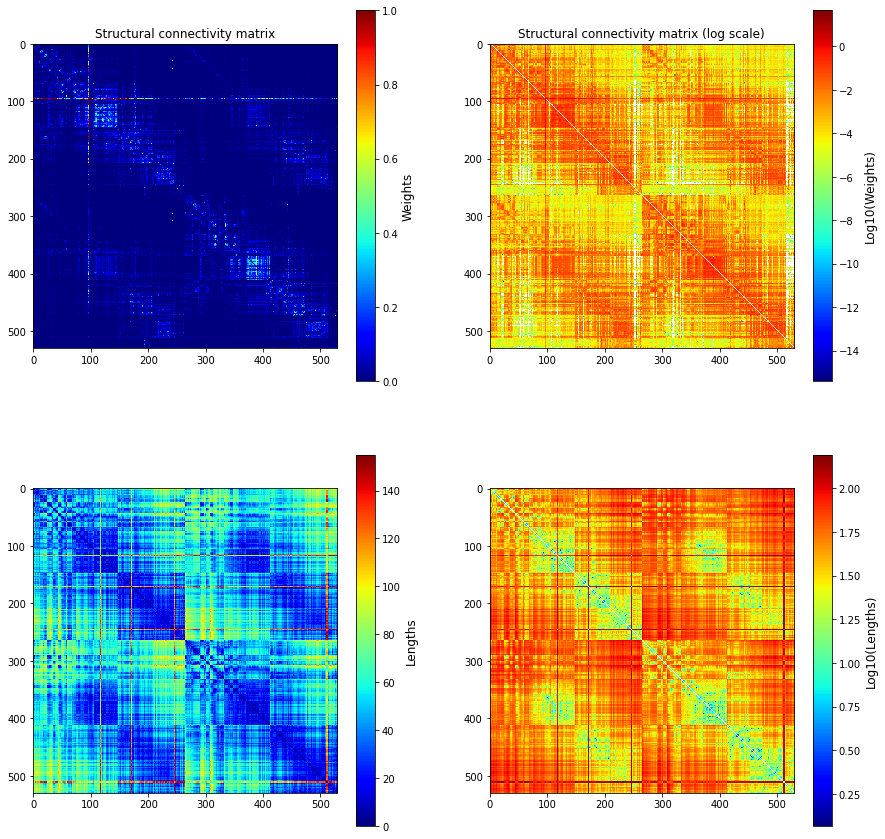

In [10]:
# Plot the resulting connectivity weights at linear and log scale
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
cs_lin = axes[0, 0].imshow(new_conn.weights, cmap='jet', aspect='equal', interpolation='none', vmax=1)
axes[0, 0].set_title('Structural connectivity matrix', fontsize=12)
axcb_lin = plt.colorbar(cs_lin, ax=axes[0, 0])
axcb_lin.set_label('Weights', fontsize=12)

cs_log = axes[0, 1].imshow(np.log10(new_conn.weights), cmap='jet', aspect='equal', interpolation='none')
axes[0, 1].set_title('Structural connectivity matrix (log scale)', fontsize=12)
axcb_log = plt.colorbar(cs_log, ax=axes[0, 1])
axcb_log.set_label('Log10(Weights)', fontsize=12)


ls_lin = axes[1, 0].imshow(new_conn.tract_lengths, cmap='jet', aspect='equal', interpolation='none')
axcb_lin = plt.colorbar(ls_lin, ax=axes[1, 0])
axcb_lin.set_label('Lengths', fontsize=12)

ls_log = axes[1, 1].imshow(np.log10(new_conn.tract_lengths), cmap='jet', aspect='equal', interpolation='none')
axcb_log = plt.colorbar(ls_log, ax=axes[1, 1])
axcb_log.set_label('Log10(Lengths)', fontsize=12)


In [11]:
inds = {}
inds["crtx"] = []
inds["m1"] = []
inds["s1brl"] = []
inds["supcol"] = []
inds["facial"] = []
inds["trigeminal"] = []
inds["ponssens_trigeminal"] = []
inds["ponssens"] = []
inds["ponsmotor"] = []
inds["thal"] = []
inds["thalspec"] = []
inds["m1thal"] = []
inds["s1brlthal"] = []
inds["ansilob"] = []
inds["dentate"] = []
inds["interposed"] = []
inds["oliv"] = []
for iR, (reg, lbl) in enumerate(zip(new_conn.region_labels, new_major_structs_labels)):
    if "Isocortex" in lbl:
        inds["crtx"].append(iR)
    if "Primary motor area" in reg and "Specific" not in reg:
        inds["m1"].append(iR)
    if "barrel" in reg and "Specific" not in reg:
        inds["s1brl"].append(iR)
    if "Superior colliculus, motor related" in reg:
        inds["supcol"].append(iR)
    if "Primary motor area" in reg and "Specific" in reg:
        inds["m1thal"].append(iR)
    if "barrel" in reg and "Specific" in reg:
        inds["s1brlthal"].append(iR)
    if "Superior colliculus, motor related" in reg:
        inds["supcol"].append(iR)
    if "Facial" in reg:
        inds["facial"] .append(iR)
    if "Spinal nucleus of the trigeminal" in reg:
        inds["trigeminal"].append(iR)
    if "Principal sensory nucleus of the trigeminal" in reg:
        inds["ponssens_trigeminal"] .append(iR)
    if "Pons Sensory" in lbl:
        inds["ponssens"] .append(iR)
    if "Pons Motor" in lbl:
        inds["ponsmotor"].append(iR)
    if "Nonspecific Thalamus" in lbl:
        inds["thal"].append(iR)
    if "Thalamus" in lbl:
        inds["thalspec"].append(iR)
    if "Ansiform lobule" in reg:
        inds["ansilob"].append(iR)
    if "Dentate nucleus" in reg:
        inds["dentate"].append(iR)
    if "Interposed nucleus" in reg:
        inds["interposed"].append(iR)
    if "Inferior olivary complex" in reg:
        inds["oliv"].append(iR)
inds["m1s1brl"] = inds["m1"]  + inds["s1brl"]
inds["sens"] = inds["trigeminal"]  + inds["ponssens_trigeminal"] + inds["s1brlthal"]
inds["motor"] = inds["m1thal"] + inds["facial"]  # inds["supcol"]  + 
inds["cereb"] = inds["ansilob"] + inds["dentate"] + inds["interposed"] + inds["oliv"]
allspecial = inds["m1s1brl"] + inds["motor"] + inds["sens"] + inds["thal"] + inds["thalspec"] + inds["cereb"]
for key, val in inds.items():
    inds[key] = np.array(val)
print(new_conn.region_labels[allspecial])

['Right Primary motor area' 'Left Primary motor area'
 'Right Primary somatosensory area, barrel field'
 'Left Primary somatosensory area, barrel field'
 'Right Facial motor nucleus' 'Left Facial motor nucleus'
 'Right Spinal nucleus of the trigeminal, caudal part'
 'Right Spinal nucleus of the trigeminal, interpolar part'
 'Right Spinal nucleus of the trigeminal, oral part'
 'Left Spinal nucleus of the trigeminal, caudal part'
 'Left Spinal nucleus of the trigeminal, interpolar part'
 'Left Spinal nucleus of the trigeminal, oral part'
 'Right Principal sensory nucleus of the trigeminal'
 'Left Principal sensory nucleus of the trigeminal'
 'Right Paraventricular nucleus of the thalamus'
 'Right Parataenial nucleus' 'Right Xiphoid thalamic nucleus'
 'Right Rhomboid nucleus' 'Right Central medial nucleus of the thalamus'
 'Right Paracentral nucleus'
 'Right Central lateral nucleus of the thalamus'
 'Right Parafascicular nucleus'
 'Right Posterior intralaminar thalamic nucleus'
 'Left Par

In [12]:
import h5py

# the method returns the tract lengths between the brain areas in the selected parcellation
def construct_tract_lengths(centres):
    n_regions = len(centres)
    tracts = np.zeros((n_regions, n_regions), dtype=float)
    for i_ind, inj in enumerate(centres):
        for i_targ, targ in enumerate(centres):
            tracts[i_ind, i_targ] = np.sqrt(
                (inj[0] - targ[0]) ** 2 + (inj[1] - targ[1]) ** 2 + (inj[2] - targ[2]) ** 2)
    return tracts

def write_connectivity_to_h5_file(connectivity, filename):
    #save the structural conn matrix
    f = h5py.File(os.path.join(data_path, filename), "w")
    for attr in ["weights", "tract_lengths", "centres", "region_labels"]:
        if attr == "region_labels":
            f.create_dataset(attr, data=getattr(connectivity, attr).astype(h5py.string_dtype(encoding='utf-8')))

        else:
            f.create_dataset(attr, data=getattr(connectivity, attr))
    f.close()  

In [13]:
np.unique(new_major_structs_labels)

array(['Left Cerebellar Cortex', 'Left Cerebellar Nuclei',
       'Left Cortical Subplate', 'Left Hippocampal Formation',
       'Left Hypothalamus', 'Left Isocortex', 'Left Medulla',
       'Left Midbrain', 'Left Nonspecific Thalamus',
       'Left Olfactory Areas', 'Left Pallidum', 'Left Pons Behavioral',
       'Left Pons Motor', 'Left Pons Sensory',
       'Left Spinal nucleus of the trigeminal', 'Left Striatum',
       'Left Thalamus', 'Right Cerebellar Cortex',
       'Right Cerebellar Nuclei', 'Right Cortical Subplate',
       'Right Hippocampal Formation', 'Right Hypothalamus',
       'Right Isocortex', 'Right Medulla', 'Right Midbrain',
       'Right Nonspecific Thalamus', 'Right Olfactory Areas',
       'Right Pallidum', 'Right Pons Behavioral', 'Right Pons Motor',
       'Right Pons Sensory', 'Right Spinal nucleus of the trigeminal',
       'Right Striatum', 'Right Thalamus'], dtype='<U38')

In [14]:
# # Write the resulting connectivity to .h5 TVB compatible file...
# write_connectivity_to_h5_file(new_conn, "Connectivity_SummedSubcortical.h5")
# # ... along with the corresponding mapping from regions to major structures.
# np.save("major_structs_labels_SummedSubcortical.npy", new_major_structs_labels)
# np.save("voxel_count_SummedSubcortical.npy", new_voxel_count)
# np.save("inds_SummedSubcortical.npy", inds)

In [15]:

# Now we need to create the specific Thalamic nuclei, one for each Isocortex node:

# Thalamus indices:
iThR = np.where(["Right Thalamus" in lbl for lbl in new_major_structs_labels])[0][0]
iThL = np.where(["Left Thalamus" in lbl for lbl in new_major_structs_labels])[0][0]
assert np.all(new_conn.region_labels[[iThR, iThL]] == ['Right Thalamus', 'Left Thalamus'])


# Isocortex indices
crtx_inds = np.where(["Isocortex" in lbl for lbl in new_major_structs_labels])[0]
n_crtx = int(len(crtx_inds))
n_crtx2 = int(n_crtx/2)
crtx_inds_R = crtx_inds[:n_crtx2]
crtx_inds_L = crtx_inds[n_crtx2:]

# All the rest indices, subcortical but not specific thalamic, but including nonspecific thalamic:
subcrtx_inds = np.arange(len(new_major_structs_labels)).astype('i')
subcrtx_inds = np.delete(subcrtx_inds, 
                         crtx_inds.tolist() + [iThR, iThL])

# Create new major_structs_labels
insert_inds_R = crtx_inds[n_crtx2-1]+1
final_major_structs_labels = insert_axis(new_major_structs_labels, 
                                         arr_to_insert=np.tile('Right Specific Thalamus', n_crtx2), 
                                         inds=[insert_inds_R])
insert_inds_L = 1+ np.where(["Left Isocortex" in lbl for lbl in final_major_structs_labels])[0][-1]
final_major_structs_labels = insert_axis(final_major_structs_labels, 
                                         arr_to_insert=np.tile('Left Specific Thalamus', n_crtx2), 
                                         inds=[insert_inds_L])
# print(final_major_structs_labels)

# Get the new indices of major structures:
final_crtx_inds = np.where(["Isocortex" in lbl for lbl in final_major_structs_labels])[0]
final_crtx_inds_R = final_crtx_inds[:n_crtx2]
final_crtx_inds_L = final_crtx_inds[n_crtx2:]
final_spec_thal_inds_R = final_crtx_inds[:n_crtx2] + n_crtx2
final_spec_thal_inds_L = final_crtx_inds[n_crtx2:] + n_crtx2
final_spec_thal_inds = final_spec_thal_inds_R.tolist() + final_spec_thal_inds_R.tolist()
final_iThR = np.where(["Right Nonspecific Thalamus" in lbl for lbl in final_major_structs_labels])[0][0]
final_iThL = np.where(["Left Nonspecific Thalamus" in lbl for lbl in final_major_structs_labels])[0][0]
final_n_regions = len(final_major_structs_labels)
# All the rest indices, subcortical but not thalamic:
final_subcrtx_inds = np.arange(final_n_regions).astype('i')
final_subcrtx_inds = np.delete(final_subcrtx_inds, 
                               final_crtx_inds.tolist() + 
                               final_spec_thal_inds_R.tolist() + 
                               final_spec_thal_inds_L.tolist() +
                               [final_iThR, final_iThL])
assert final_n_regions == new_conn.number_of_regions + n_crtx
assert np.all(final_major_structs_labels[final_crtx_inds_R] == "Right Isocortex")
assert np.all(final_major_structs_labels[final_crtx_inds_L] == "Left Isocortex")
assert np.all(final_major_structs_labels[final_spec_thal_inds_R] == "Right Specific Thalamus")
assert np.all(final_major_structs_labels[final_spec_thal_inds_L] == "Left Specific Thalamus")
assert np.all(final_major_structs_labels[[final_iThR, final_iThL]] == ['Right Nonspecific Thalamus', 
                                                                       'Left Nonspecific Thalamus'])

# Create new voxel counts:
# Thalamus voxel counts
voxel_count_th = new_voxel_count[iThL]
assert new_voxel_count[iThL] == new_voxel_count[iThR] == voxel_count_th
voxel_count_spec_th = int(voxel_count_th / n_crtx2)
final_voxel_count = insert_axis(new_voxel_count, 
                                arr_to_insert=np.tile(voxel_count_spec_th, n_crtx2), 
                                inds=[insert_inds_R])
final_voxel_count = insert_axis(final_voxel_count, 
                                arr_to_insert=np.tile(voxel_count_spec_th, n_crtx2), 
                                inds=[insert_inds_L])
assert np.all(final_voxel_count[final_spec_thal_inds_R] == voxel_count_spec_th)
assert np.all(final_voxel_count[final_spec_thal_inds_L] == voxel_count_spec_th)

# Create new region labels
final_region_labels = insert_axis(new_conn.region_labels, 
                                  arr_to_insert=np.array(['Right Specific Thalamus to ' + reg.split('Right ')[-1]
                                                          for reg in new_conn.region_labels[crtx_inds[:n_crtx2]]]), 
                                  inds=[insert_inds_R])
final_region_labels = insert_axis(final_region_labels, 
                                  arr_to_insert=np.array(['Left Specific Thalamus to ' + reg.split('Left ')[-1]
                                                          for reg in new_conn.region_labels[crtx_inds[n_crtx2:]]]), 
                                  inds=[insert_inds_L])
assert np.all(np.array([reg.split("Right ")[-1] for reg in final_region_labels[final_crtx_inds_R]]) == 
              np.array([reg.split("Right Specific Thalamus to ")[-1] for reg in final_region_labels[final_spec_thal_inds_R]]))
assert np.all(np.array([reg.split("Left ")[-1] for reg in final_region_labels[final_crtx_inds_L]]) == 
              np.array([reg.split("Left Specific Thalamus to ")[-1] for reg in final_region_labels[final_spec_thal_inds_L]]))
              
# Create new centers:
final_centres = insert_axis(new_conn.centres, 
                            arr_to_insert=np.repeat([new_conn.centres[iThR]], n_crtx2, axis=0), 
                            inds=[insert_inds_R])
final_centres = insert_axis(final_centres, 
                            arr_to_insert=np.repeat([new_conn.centres[iThL]], n_crtx2, axis=0), 
                            inds=[insert_inds_L])


def expand_2D_with_zeros(arr, inds, nregs):
    new_arr = insert_axis(arr, 
                          arr_to_insert=np.tile(0.0, (nregs, arr.shape[1])), 
                          inds=[inds[0]], axis=0)
    new_arr = insert_axis(new_arr, 
                          arr_to_insert=np.tile(0.0, (nregs, new_arr.shape[1])), 
                          inds=[inds[1]], axis=0)
    new_arr = insert_axis(new_arr, 
                          arr_to_insert=np.tile(0.0, (new_arr.shape[0], nregs)), 
                          inds=[inds[0]], axis=1)
    new_arr = insert_axis(new_arr, 
                          arr_to_insert=np.tile(0.0, (new_arr.shape[0], nregs)), 
                          inds=[inds[1]], axis=1)
    return new_arr

# Create new weights:
final_weights = expand_2D_with_zeros(new_conn.weights, [insert_inds_R, insert_inds_L], n_crtx2)
# Connections Specific Thalami -> Cortex = Specific Thalamus -> Cortex:
final_weights[final_crtx_inds_R, final_spec_thal_inds_R] = new_conn.weights[crtx_inds_R, iThR]
final_weights[final_crtx_inds_L, final_spec_thal_inds_L] = new_conn.weights[crtx_inds_L, iThL]
# Connections  Cortex -> Specific Thalami = Cortex -> Specific Thalamus:
final_weights[final_spec_thal_inds_R, final_crtx_inds_R] = new_conn.weights[iThR, crtx_inds_R]
final_weights[final_spec_thal_inds_L, final_crtx_inds_L] = new_conn.weights[iThL, crtx_inds_L]
# Connections Subcortex -> Specific Thalami = Subcortex -> Specific Thalamus / n_specific_thalami:
final_weights[final_spec_thal_inds_R[:, None], final_subcrtx_inds[None, :]] = np.tile(new_conn.weights[iThR, subcrtx_inds]/n_crtx2, (n_crtx2, 1))
final_weights[final_spec_thal_inds_L[:, None], final_subcrtx_inds[None, :]] = np.tile(new_conn.weights[iThL, subcrtx_inds]/n_crtx2, (n_crtx2, 1))
# Connections Specific Thalami -> Subcortex  =  Specific Thalamus -> Subcortex / n_specific_thalami:
final_weights[final_subcrtx_inds[:, None], final_spec_thal_inds_R[None, :]] = np.tile(new_conn.weights[subcrtx_inds, iThR]/n_crtx2, (n_crtx2, 1)).T
final_weights[final_subcrtx_inds[:, None], final_spec_thal_inds_L[None, :]] = np.tile(new_conn.weights[subcrtx_inds, iThL]/n_crtx2, (n_crtx2, 1)).T
# No connections Specific Thalami <-> Specific Thalami!!!

# Create new tract_lengths:
final_tract_lengths = expand_2D_with_zeros(new_conn.tract_lengths, [insert_inds_R, insert_inds_L], n_crtx2)
# Connections Specific Thalami -> Cortex = Specific Thalamus -> Cortex:
final_tract_lengths[final_crtx_inds_R, final_spec_thal_inds_R] = new_conn.tract_lengths[crtx_inds_R, iThR]
final_tract_lengths[final_crtx_inds_L, final_spec_thal_inds_L] = new_conn.tract_lengths[crtx_inds_L, iThL]
# Connections  Cortex -> Specific Thalami = Cortex -> Specific Thalamus:
final_tract_lengths[final_spec_thal_inds_R, final_crtx_inds_R] = new_conn.tract_lengths[iThR, crtx_inds_R]
final_tract_lengths[final_spec_thal_inds_L, final_crtx_inds_L] = new_conn.tract_lengths[iThL, crtx_inds_L]
# Connections Subcortex -> Specific Thalami = Subcortex -> Specific Thalamus:

# Connections Subcortex -> Specific Thalami = Subcortex -> Specific Thalamus:
final_tract_lengths[final_spec_thal_inds_R[:, None], final_subcrtx_inds[None, :]] = np.tile(new_conn.tract_lengths[iThR, subcrtx_inds], (n_crtx2, 1))
final_tract_lengths[final_spec_thal_inds_L[:, None], final_subcrtx_inds[None, :]] = np.tile(new_conn.tract_lengths[iThL, subcrtx_inds], (n_crtx2, 1))
# Connections Specific Thalami -> Subcortex  =  Specific Thalamus -> Subcortex:
final_tract_lengths[final_subcrtx_inds[:, None], final_spec_thal_inds_R[None, :]] = np.tile(new_conn.tract_lengths[subcrtx_inds, iThR], (n_crtx2, 1)).T
final_tract_lengths[final_subcrtx_inds[:, None], final_spec_thal_inds_L[None, :]] = np.tile(new_conn.tract_lengths[subcrtx_inds, iThL], (n_crtx2, 1)).T
# No connections Specific Thalami <-> Specific Thalami!!!

# Finally delete the merged Right/Left Thalamus:
iTh = []
iTh.append(np.where(["Right Thalamus" in lbl for lbl in final_region_labels])[0][0])
iTh.append(np.where(["Left Thalamus" in lbl for lbl in final_region_labels])[0][0])
iTh = np.unique(iTh)
final_major_structs_labels = np.delete(final_major_structs_labels, iTh)
final_voxel_count = np.delete(final_voxel_count, iTh)
final_region_labels = np.delete(final_region_labels, iTh)
final_centres = np.delete(final_centres, iTh)
final_weights = np.delete(final_weights, iTh, axis=0)
final_weights = np.delete(final_weights, iTh, axis=1)
final_tract_lengths = np.delete(final_tract_lengths, iTh, axis=0)
final_tract_lengths = np.delete(final_tract_lengths, iTh, axis=1)

final_connectivity = Connectivity(weights=final_weights, 
                                  tract_lengths=final_tract_lengths, 
                                  centres=final_centres,
                                  region_labels=final_region_labels)


/home/docker/env/neurosci/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/docker/env/neurosci/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


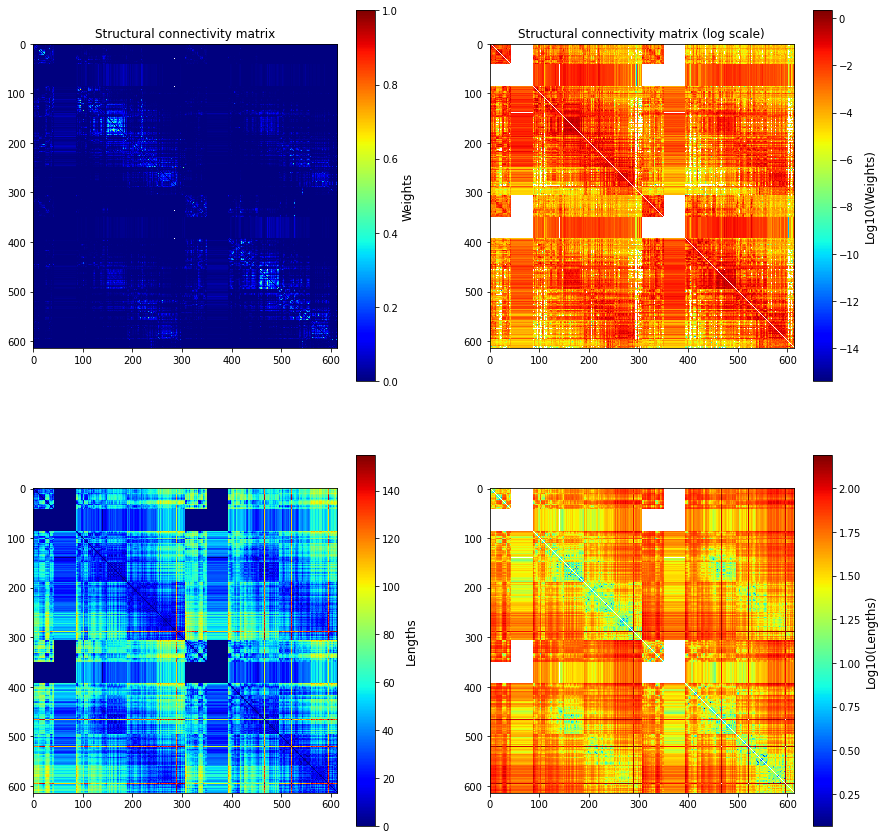

In [16]:

# Plot the resulting connectivity weights at linear and log scale
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
cs_lin = axes[0, 0].imshow(final_connectivity.weights, cmap='jet', aspect='equal', interpolation='none', vmax=1)
axes[0, 0].set_title('Structural connectivity matrix', fontsize=12)
axcb_lin = plt.colorbar(cs_lin, ax=axes[0, 0])
axcb_lin.set_label('Weights', fontsize=12)

cs_log = axes[0, 1].imshow(np.log10(final_connectivity.weights), cmap='jet', aspect='equal', interpolation='none')
axes[0, 1].set_title('Structural connectivity matrix (log scale)', fontsize=12)
axcb_log = plt.colorbar(cs_log, ax=axes[0, 1])
axcb_log.set_label('Log10(Weights)', fontsize=12)


ls_lin = axes[1, 0].imshow(final_connectivity.tract_lengths, cmap='jet', aspect='equal', interpolation='none')
axcb_lin = plt.colorbar(ls_lin, ax=axes[1, 0])
axcb_lin.set_label('Lengths', fontsize=12)

ls_log = axes[1, 1].imshow(np.log10(final_connectivity.tract_lengths), cmap='jet', aspect='equal', interpolation='none')
axcb_log = plt.colorbar(ls_log, ax=axes[1, 1])
axcb_log.set_label('Log10(Lengths)', fontsize=12)




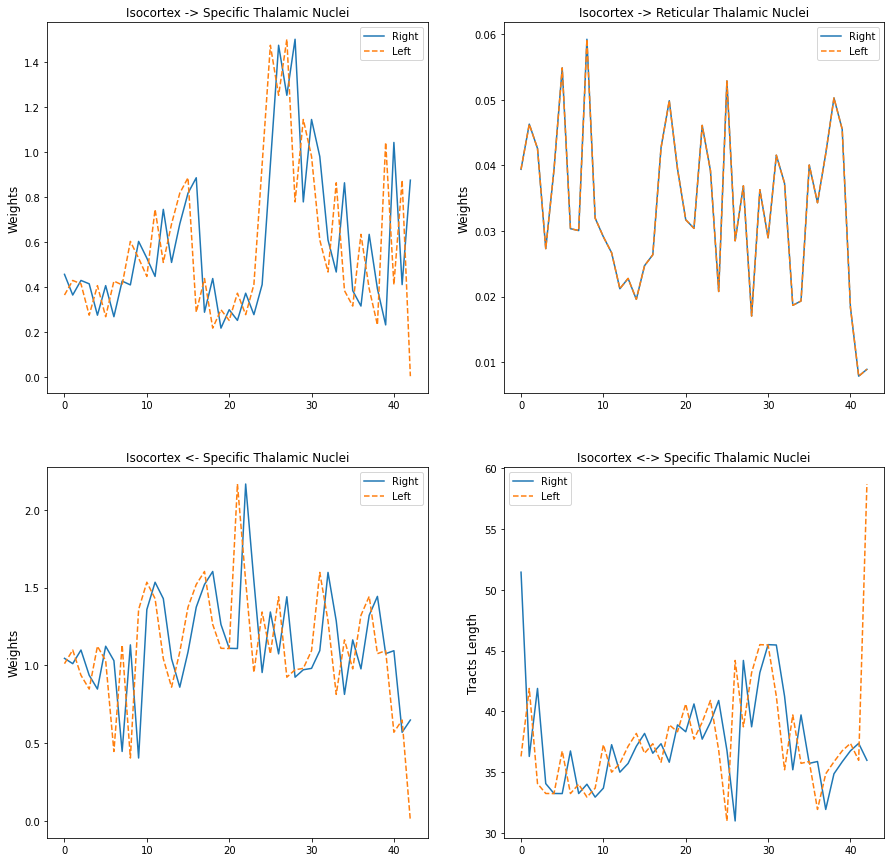

In [17]:
# Plot the resulting connectivity weights and tract lengths beween Isocortex and Specific Thalamic Nuclei

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
cs_spec_R = axes[0, 0].plot(final_connectivity.weights[final_crtx_inds_R, final_spec_thal_inds_R], "-", label="Right")
cs_spec_L = axes[0, 0].plot(final_connectivity.weights[final_crtx_inds_L, final_spec_thal_inds_L], "--", label="Left")
axes[0, 0].set_title('Isocortex -> Specific Thalamic Nuclei', fontsize=12)
axes[0, 0].set_ylabel('Weights', fontsize=12)
axes[0, 0].legend()

cs_rtn_R = axes[0, 1].plot(crtx_to_rtn_conns[0, :43], "-", label="Right")
cs_rtn_L = axes[0, 1].plot(crtx_to_rtn_conns[1, 43:], "--", label="Left")
axes[0, 1].set_title('Isocortex -> Reticular Thalamic Nuclei', fontsize=12)
axes[0, 1].set_ylabel('Weights', fontsize=12)
axes[0, 1].legend()

cs_lin_R = axes[1, 0].plot(final_connectivity.weights[final_spec_thal_inds_R, final_crtx_inds_R], "-", label="Right")
cs_lin_L = axes[1, 0].plot(final_connectivity.weights[final_spec_thal_inds_L, final_crtx_inds_L], "--", label="Left")
axes[1, 0].set_title('Isocortex <- Specific Thalamic Nuclei', fontsize=12)
axes[1, 0].set_ylabel('Weights', fontsize=12)
axes[1, 0].legend()


tl_lin_R = axes[1, 1].plot(final_connectivity.tract_lengths[final_spec_thal_inds_R, final_crtx_inds_R], "-", label="Right")
tl_lin_L = axes[1, 1].plot(final_connectivity.tract_lengths[final_spec_thal_inds_L, final_crtx_inds_L], "--", label="Left")
axes[1, 1].set_title('Isocortex <-> Specific Thalamic Nuclei', fontsize=12)
axes[1, 1].set_ylabel('Tracts Length', fontsize=12)
axes[1, 1].legend()



In [18]:
inds = {}
inds["crtx"] = []
inds["m1"] = []
inds["s1brl"] = []
inds["supcol"] = []
inds["facial"] = []
inds["trigeminal"] = []
inds["ponssens_trigeminal"] = []
inds["ponssens"] = []
inds["ponsmotor"] = []
inds["thal"] = []
inds["thalspec"] = []
inds["m1thal"] = []
inds["s1brlthal"] = []
inds["ansilob"] = []
inds["dentate"] = []
inds["interposed"] = []
inds["oliv"] = []
for iR, (reg, lbl) in enumerate(zip(final_connectivity.region_labels, final_major_structs_labels)):
    if "Isocortex" in lbl:
        inds["crtx"].append(iR)
    if "Primary motor area" in reg and "Specific" not in reg:
        inds["m1"].append(iR)
    if "barrel" in reg and "Specific" not in reg:
        inds["s1brl"].append(iR)
    if "Superior colliculus, motor related" in reg:
        inds["supcol"].append(iR)
    if "Primary motor area" in reg and "Specific" in reg:
        inds["m1thal"].append(iR)
    if "barrel" in reg and "Specific" in reg:
        inds["s1brlthal"].append(iR)
    if "Superior colliculus, motor related" in reg:
        inds["supcol"].append(iR)
    if "Facial" in reg:
        inds["facial"] .append(iR)
    if "Spinal nucleus of the trigeminal" in reg:
        inds["trigeminal"].append(iR)
    if "Principal sensory nucleus of the trigeminal" in reg:
        inds["ponssens_trigeminal"] .append(iR)
    if "Pons Sensory" in lbl:
        inds["ponssens"] .append(iR)
    if "Pons Motor" in lbl:
        inds["ponsmotor"].append(iR)
    if "Nonspecific Thalamus" in lbl:
        inds["thal"].append(iR)
    if "Specific Thalamus" in lbl:
        inds["thalspec"].append(iR)
    if "Ansiform lobule" in reg:
        inds["ansilob"].append(iR)
    if "Dentate nucleus" in reg:
        inds["dentate"].append(iR)
    if "Interposed nucleus" in reg:
        inds["interposed"].append(iR)
    if "Inferior olivary complex" in reg:
        inds["oliv"].append(iR)
inds["m1s1brl"] = inds["m1"]  + inds["s1brl"]
inds["sens"] = inds["trigeminal"]  + inds["ponssens_trigeminal"] + inds["s1brlthal"]
inds["motor"] = inds["m1thal"] + inds["facial"]  # inds["supcol"]  + 
inds["cereb"] = inds["ansilob"] + inds["dentate"] + inds["interposed"] + inds["oliv"]
allspecial = inds["m1s1brl"] + inds["motor"] + inds["sens"] + inds["thal"] + inds["cereb"]
for key, val in inds.items():
    inds[key] = np.array(val)
print(final_connectivity.region_labels[allspecial])

['Right Primary motor area' 'Left Primary motor area'
 'Right Primary somatosensory area, barrel field'
 'Left Primary somatosensory area, barrel field'
 'Right Specific Thalamus to Primary motor area'
 'Left Specific Thalamus to Primary motor area'
 'Right Facial motor nucleus' 'Left Facial motor nucleus'
 'Right Spinal nucleus of the trigeminal, caudal part'
 'Right Spinal nucleus of the trigeminal, interpolar part'
 'Right Spinal nucleus of the trigeminal, oral part'
 'Left Spinal nucleus of the trigeminal, caudal part'
 'Left Spinal nucleus of the trigeminal, interpolar part'
 'Left Spinal nucleus of the trigeminal, oral part'
 'Right Principal sensory nucleus of the trigeminal'
 'Left Principal sensory nucleus of the trigeminal'
 'Right Specific Thalamus to Primary somatosensory area, barrel field'
 'Left Specific Thalamus to Primary somatosensory area, barrel field'
 'Right Paraventricular nucleus of the thalamus'
 'Right Parataenial nucleus' 'Right Xiphoid thalamic nucleus'
 'Ri

In [19]:
np.unique(final_major_structs_labels)

array(['Left Cerebellar Cortex', 'Left Cerebellar Nuclei',
       'Left Cortical Subplate', 'Left Hippocampal Formation',
       'Left Hypothalamus', 'Left Isocortex', 'Left Medulla',
       'Left Midbrain', 'Left Nonspecific Thalamus',
       'Left Olfactory Areas', 'Left Pallidum', 'Left Pons Behavioral',
       'Left Pons Motor', 'Left Pons Sensory', 'Left Specific Thalamus',
       'Left Spinal nucleus of the trigeminal', 'Left Striatum',
       'Right Cerebellar Cortex', 'Right Cerebellar Nuclei',
       'Right Cortical Subplate', 'Right Hippocampal Formation',
       'Right Hypothalamus', 'Right Isocortex', 'Right Medulla',
       'Right Midbrain', 'Right Nonspecific Thalamus',
       'Right Olfactory Areas', 'Right Pallidum', 'Right Pons Behavioral',
       'Right Pons Motor', 'Right Pons Sensory',
       'Right Specific Thalamus',
       'Right Spinal nucleus of the trigeminal', 'Right Striatum'],
      dtype='<U38')

In [20]:
# Write the resulting connectivity to .h5 TVB compatible file...
write_connectivity_to_h5_file(final_connectivity, "Connectivity_Thals.h5")  # _SummedSubcortical
# ... along with the corresponding mapping from regions to major structures.
np.save("major_structs_labels_Thals.npy", final_major_structs_labels) # _SummedSubcortical
np.save("voxel_count_Thals.npy", final_voxel_count) # _SummedSubcortical
np.save("crtx_to_rtn_conns.npy", crtx_to_rtn_conns)
np.save("inds_Thals.npy", inds) # _SummedSubcortical


In [21]:
from six import string_types
from collections import OrderedDict
from tvb.contrib.scripts.utils.data_structures_utils import is_integer, is_float
from examples.tvb_nest.notebooks.cerebellum.utils import print_conn
    

def _maxrow(maxrow, weights):
    if maxrow < 1:
        cum = np.maximum(maxrow, 0.1)
        maxrow_label = "%g%%" % (100*cum)
        weights_sum = 0.0
        weights_total = weights.sum()
        maxrow = 0
        for weight in weights:
            maxrow += 1
            weights_sum += weight
            if weights_sum / weights_total >= cum:
                break
    else:
        maxrow = int(maxrow)
        maxrow_label = "%d" % maxrow
    return maxrow, maxrow_label


def print_weights_from(label, inds, region_labels, weights, maxrow=0.9):
    for iH, hemi in enumerate(["Right", "Left"]):
        arginds = np.argsort(weights[inds[iH], :])[::-1]
        out_maxrow, maxrow_label = _maxrow(maxrow, weights[inds[iH], arginds].squeeze())
        d = OrderedDict()
        d[("Region", 55)] = ["%d.%s" % (iR, region_labels[iR]) for iR in arginds]
        d[("Weight", 30)] = weights[inds[iH], arginds]
        d[("Total weights to", 30)] = np.nansum(weights[arginds], axis=1)
        print_conn(d, prnt="\nStronger %s connections from %s %s to:\n" % (maxrow_label, hemi, label), 
                   maxrow=out_maxrow, printit=True);
    
    
def print_weights_to(label, inds, region_labels, weights, maxrow=0.9):
    for iH, hemi in enumerate(["Right", "Left"]):
        arginds = np.argsort(weights[:, inds[iH]])[::-1]
        out_maxrow, maxrow_label = _maxrow(maxrow, weights[inds[iH], arginds].squeeze())
        d = OrderedDict()
        d[("Region", 55)] = ["%d.%s" % (iR, region_labels[iR]) for iR in arginds]
        d[("Weight", 30)] = weights[arginds, inds[iH]]
        d[("Total weights from", 30)] = np.nansum(weights[:, arginds], axis=0)
        print_conn(d, prnt="\nStronger %s connections to %s %s from:\n" % (maxrow_label, hemi, label), 
                   maxrow=out_maxrow, printit=True);
        

In [22]:
d = OrderedDict()
d[("Region", 55)] = ["%d.%s" % (iR, reg[:50]) for iR, reg in enumerate(final_connectivity.region_labels)]
d[("Major Structure", 30)] = final_major_structs_labels
d[("Voxels", 10)] = final_voxel_count
d[("Total weights to/from", 21)] = np.array(["%0.3f/%0.3f" % ( wt, wf) 
                                             for wt, wf in zip(np.nansum(final_connectivity.weights, axis=1), 
                                                               np.nansum(final_connectivity.weights, axis=0))])
print_conn(d, prnt="", printit=True);

Region.................................................Major Structure...............Voxels....Total weights to/from
--------------------------------------------------------------------------------------------------------------------
0.Right Frontal pole, cerebral cortex..................Right Isocortex...............514.......3.107/5.948..........
1.Right Primary motor area.............................Right Isocortex...............11760.....1.855/6.174..........
2.Right Secondary motor area...........................Right Isocortex...............10098.....2.315/6.759..........
3.Right Primary somatosensory area, nose...............Right Isocortex...............1358......1.197/5.138..........
4.Right Primary somatosensory area, barrel field.......Right Isocortex...............10306.....1.371/6.229..........
5.Right Primary somatosensory area, lower limb.........Right Isocortex...............3254......1.829/5.456..........
6.Right Primary somatosensory area, mouth..............Right Iso

In [23]:
print("SENSORY PATHWAY:\n")
print_weights_from("Spinal nucleus of the trigeminal", inds["trigeminal"], 
                   final_connectivity.region_labels, final_connectivity.weights, maxrow=0.9)
print_weights_to("Principal sensory nucleus of the trigeminal", inds["ponssens_trigeminal"], 
                 final_connectivity.region_labels, final_connectivity.weights, maxrow=0.9)
print_weights_from("Principal sensory nucleus of the trigeminal", inds["ponssens_trigeminal"], 
                   final_connectivity.region_labels, final_connectivity.weights, maxrow=0.9)
print_weights_to("Ansiform lobule", inds["ansilob"], 
                final_connectivity.region_labels, final_connectivity.weights, maxrow=0.95)

print("\n\n\nMOTOR PATHWAY:\n")
print_weights_from("Primary motor area", inds["m1"], final_connectivity.region_labels, final_connectivity.weights, maxrow=0.9)
# print_weights_to("Superior colliculus, motor related", inds["supcol"], final_connectivity.region_labels, final_connectivity.weights, maxrow=10)
# print_weights_from("Superior colliculus, motor related", inds["supcol"], final_connectivity.region_labels, final_connectivity.weights, maxrow=10)
print_weights_to("Facial motor nucleus", inds["facial"], final_connectivity.region_labels, final_connectivity.weights, maxrow=0.9)



SENSORY PATHWAY:


Stronger 90% connections from Right Spinal nucleus of the trigeminal to:
Region.................................................Weight........................Total weights to..............
-------------------------------------------------------------------------------------------------------------------
259.Right Paratrigeminal nucleus.......................0.134526......................0.677624......................
257.Right Spinal nucleus of the trigeminal, interpolar part0.113527......................2.23759.......................
272.Right Medullary reticular nucleus, dorsal part.....0.082372......................7.34588.......................
271.Right Medullary reticular nucleus..................0.0760936.....................8.0071........................
262.Right Nucleus ambiguus.............................0.0692334.....................9.85279.......................
279.Right Parapyramidal nucleus........................0.0578868.....................6.24536


Stronger 90% connections to Left Facial motor nucleus from:
Region.................................................Weight........................Total weights from............
-------------------------------------------------------------------------------------------------------------------
569.Left Nucleus ambiguus..............................0.282627......................11.0569.......................
583.Left Paragigantocellular reticular nucleus, lateral part0.234175......................7.39359.......................
575.Left Linear nucleus of the medulla.................0.220768......................8.60325.......................
555.Left Subceruleus nucleus...........................0.212074......................12.4527.......................
584.Left Nucleus of Roller.............................0.2049........................6.59845.......................
573.Left Intermediate reticular nucleus................0.19545.......................8.6481........................
547.Le

In [24]:
import networkx as nx  # https://networkx.org/
from mpl_toolkits.mplot3d import Axes3D


def conn_to_graph(conn, major_structs_labels, voxel_count):
    
    G = nx.DiGraph()
    # G.add_edge('A', 'B', weight=4)
    nodes = []
    for iR, (reg, centre, msl, vc) in enumerate(zip(conn.region_labels, conn.centres, 
                                                    major_structs_labels, voxel_count)):
        nodes.append(reg)
        G.add_node(nodes[-1], ind=iR, centre=centre, major_structure_label=msl, vc=vc)
        
    for iR1, reg1 in enumerate(nodes):
        for iR2, reg2 in enumerate(nodes):
            G.add_edge(reg1, reg2, 
                       weight=conn.weights[iR2, iR1], 
                       distance=1.0/conn.weights[iR2, iR1] if conn.weights[iR2, iR1] > 0 else np.inf, 
                       tract_length=conn.tract_lengths[iR2, iR1])
        
    return G
        
    

def plot_G_conn_3D(G, nodes_kwgs={'s': 100, 'ec':"w"}, 
                   edges_kwgs={'color':"tab:gray", 'alpha': 0.01}, show=True):

    node_centres = nx.get_node_attributes(G, "centre")

    # 3d layout
    pos = nx.rescale_layout_dict(node_centres)

    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    # Create the 3D figure
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, **nodes_kwgs)

    # Plot the edges
    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, **edges_kwgs)


    def _format_axes(ax):
        """Visualization options for the 3D axes."""
        # Turn gridlines off
        ax.grid(False)
        # Suppress tick labels
        for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
            dim.set_ticks([])
        # Set axes labels
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")


    _format_axes(ax)
    fig.tight_layout()
    
    if show:
        plt.show()
    
    return fig, ax


In [25]:
# G = conn_to_graph(final_connectivity, final_major_structs_labels, final_voxel_count)
# source = "Right Spinal nucleus of the trigeminal"
# target = 'Right Ansiform lobule' 

# print(G.nodes())

# sp = nx.shortest_path(G, source, target, weight='distance')  # distance = 1/weight
# print("Shortest Path:\n", sp)

# spl = nx.shortest_path_length(G, source, target, weight='distance') 
# print("Shortest Path Length:\n", spl)

# w = 1.0 / spl / (len(sp) - 1)
# print("Shortest Path Weight = 1.0 / ShortestPathLength / (len(ShortestPath)-1):\n", w)


# # For interactive plotting:
# %matplotlib notebook 

# plot_G_conn_3D(G)

In [26]:
# # Summarize also the Cerebellar Cortices and Nuclei:
# major_structures_to_merge = ['Cerebellar Cortex', "Cerebellar Nuclei"]
# exclude_regions={}

# # For bilateral merging:
# major_structures_to_merge, exclude_regions = unilateral_to_bilateral(major_structures_to_merge, exclude_regions)

# merged_cereb_conn, merged_cereb_major_structs_labels, merged_cereb_voxel_count = \
#     merge_major_structures(final_connectivity, 
#                            major_structures_to_merge,
#                            final_major_structs_labels, final_voxel_count,
#                            exclude_regions=exclude_regions, weight_fun=np.nansum)

# inds = {}
# inds["crtx"] = []
# inds["m1"] = []
# inds["s1brl"] = []
# inds["supcol"] = []
# inds["facial"] = []
# inds["trigeminal"] = []
# inds["ponssens_trigeminal"] = []
# inds["ponssens"] = []
# inds["ponsmotor"] = []
# inds["thal"] = []
# inds["thalspec"] = []
# inds["m1thal"] = []
# inds["s1brlthal"] = []
# inds["cerebcrtx"] = []
# inds["cerebnucleus"] = []
# inds["oliv"] = []
# for iR, (reg, lbl) in enumerate(zip(merged_cereb_conn.region_labels, merged_cereb_major_structs_labels)):
#     if "Isocortex" in lbl:
#         inds["crtx"].append(iR)
#     if "Primary motor area" in reg and "Specific" not in reg:
#         inds["m1"].append(iR)
#     if "barrel" in reg and "Specific" not in reg:
#         inds["s1brl"].append(iR)
#     if "Superior colliculus, motor related" in reg:
#         inds["supcol"].append(iR)
#     if "Primary motor area" in reg and "Specific" in reg:
#         inds["m1thal"].append(iR)
#     if "barrel" in reg and "Specific" in reg:
#         inds["s1brlthal"].append(iR)
#     if "Superior colliculus, motor related" in reg:
#         inds["supcol"].append(iR)
#     if "Facial" in reg:
#         inds["facial"] .append(iR)
#     if "Spinal nucleus of the trigeminal" in reg:
#         inds["trigeminal"].append(iR)
#     if "Principal sensory nucleus of the trigeminal" in reg:
#         inds["ponssens_trigeminal"] .append(iR)
#     if "Pons Sensory" in lbl:
#         inds["ponssens"] .append(iR)
#     if "Pons Motor" in lbl:
#         inds["ponsmotor"].append(iR)
#     if "Nonspecific Thalamus" in lbl:
#         inds["thal"].append(iR)
#     if "Specific Thalamus" in lbl:
#         inds["thalspec"].append(iR)
#     if "Cerebellar Cortex" in reg:
#         inds["cerebcrtx"].append(iR)
#     if "Cerebellar Nuclei" in reg:
#         inds["cerebnucleus"].append(iR)
#     if "Inferior olivary complex" in reg:
#         inds["oliv"].append(iR)
# inds["m1s1brl"] = inds["m1"]  + inds["s1brl"]
# inds["sens"] = inds["trigeminal"]  + inds["ponssens_trigeminal"] + inds["s1brlthal"]
# inds["motor"] = inds["m1thal"] + inds["facial"]  # inds["supcol"]  + 
# inds["cereb"] = inds["cerebcrtx"] + inds["cerebnucleus"] + inds["oliv"]
# allspecial = inds["m1s1brl"] + inds["motor"] + inds["sens"] + inds["thal"] + inds["cereb"]
# for key, val in inds.items():
#     inds[key] = np.array(val)
# print(merged_cereb_conn.region_labels[allspecial])

In [27]:
# # Write the resulting connectivity to .h5 TVB compatible file...
# write_connectivity_to_h5_file(merged_cereb_conn, "Connectivity_SummedSubcortical_Thals_SummedCereb.h5")
# # ... along with the corresponding mapping from regions to major structures.
# np.save("major_structs_labels_SummedSubcortical_Thals_SummedCereb.npy", merged_cereb_major_structs_labels)
# np.save("voxel_count_SummedSubcortical_Thals_SummedCereb.npy", merged_cereb_voxel_count)
# np.save("inds_SummedSubcortical_Thals_SummedCereb.npy", inds)
